# Data preparation and exploration

We prepare the KLIFS dataset to be used for `kissim` encoding and comparison.

- Fetch all structures in KLIFS (metadata).
- Filter dataset by
  - Species
  - DFG conformation (optional)
  - Resolution
  - Quality score
  - Maximum number of mutations in the pocket
  - Maximum number of missing residues in the pocket (most will be caught by quality score already) 
  - Best struture per kinase-PDB pair
- Save the KLIFS structure IDs for the filtered dataset.

__Note__: The KLIFS data is prepared only on the basis of the structures' metadata from KLIFS. Additional filtering will happen during fingerprint generation, where the actual structural data (coordiantes ect.) are used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging

import pandas as pd
from opencadd.databases.klifs import setup_remote, setup_local

from src.data.structures import filters, explorer

In [3]:
logging.basicConfig(level=logging.INFO)
pd.set_option("display.max_columns", 50)

In [4]:
SPECIES = "Human"
RESOLUTION_MAX = 3
QUALITYSCORE_MIN = 6
N_ALLOWED_MUTATIONS = 3
N_ALLOWED_MISSING_RESIDUES = 8

HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"

## Fetch structures (metadata)

In [5]:
klifs_session = setup_local(DATA / "external/structures/20210902_KLIFS_HUMAN")

structures = klifs_session.structures.all_structures()
print(structures.shape)
structures.head()

INFO:opencadd.databases.klifs.api:Set up local session...
INFO:opencadd.databases.klifs.local:Load overview.csv...
INFO:opencadd.databases.klifs.local:Load KLIFS_export.csv...
INFO:opencadd.databases.klifs.local:Merge both csv files...
INFO:opencadd.databases.klifs.local:Add paths to coordinate folders to structures...
INFO:opencadd.databases.klifs.local:Add KLIFS IDs to structures (uses remote since not available locally!)...
INFO:opencadd.databases.klifs.api:Local session is ready!


(11806, 41)


,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,1,3dko,A,A,Human,415,EphA7,Eph,TK,RVIGA_EFGEVCSVAIKTLDFLCEASIMGQFDPNVVHLEGVMIVIE...,IHZ,-,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,-,out,in,2.00,8.1,3,7,0.944,2.254,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,True,False,False,NaN,NaN,NaN,HUMAN/EphA7/3dko_altA_chainA
1,3,3dko,B,A,Human,415,EphA7,Eph,TK,RVIGA_EFGEVCSVAIKTLDFLCEASIMGQFDPNVVHLEGVMIVIE...,IHZ,-,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,-,out,in,2.00,8.1,3,7,0.944,2.254,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,True,False,False,NaN,NaN,NaN,HUMAN/EphA7/3dko_altB_chainA
2,5,3v8t,B,A,Human,474,ITK,Tec,TK,QEIGSG___LVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,477,-,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",-,in,in,2.00,7.8,4,6,0.842,2.047,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/3v8t_altB_chainA
3,6,4kio,A,D,Human,474,ITK,Tec,TK,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,G6K,-,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",-,in,in,2.18,8.6,1,10,0.842,2.151,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/4kio_altA_chainD
4,7,4kio,B,C,Human,474,ITK,Tec,TK,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,G5K,-,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",-,in,in,2.18,9.0,0,10,0.840,2.148,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/4kio_altB_chainC


In [6]:
klifs_session = setup_remote()

kinases_short = klifs_session.kinases.all_kinases()
kinases = klifs_session.kinases.by_kinase_klifs_id(kinases_short["kinase.klifs_id"].to_list())
structures = pd.merge(structures, kinases[["kinase.klifs_id", "kinase.pocket"]])

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


## Explore structures in full dataset

### Species, DFG/aC-helix conformations, ligand

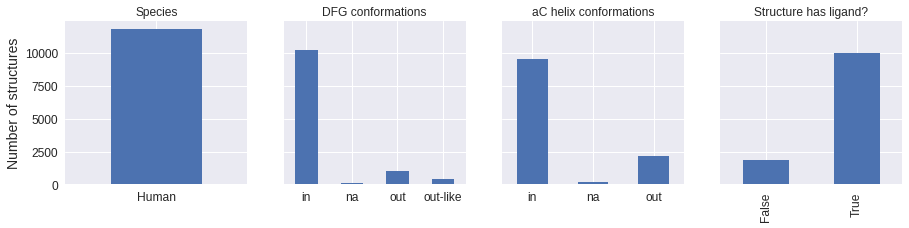

In [7]:
explorer.plot_important_categories(structures);

### Resolution vs. quality score

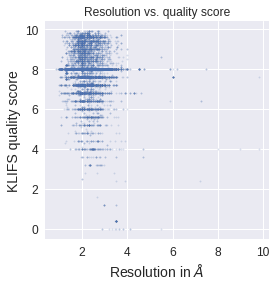

In [8]:
explorer.plot_resolution_vs_qualityscore(structures);

### Number of structures per kinase-PDB pair

How many kinase-PDB pairs are represented by how many structures?

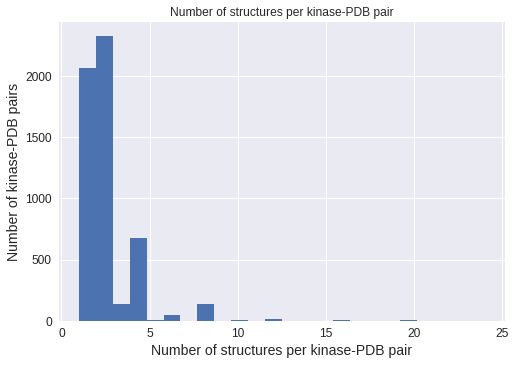

In [9]:
explorer.plot_number_of_structures_per_kinase_pdb_pair(structures);

## Filter and save structures

In [10]:
n_structures = {}
n_kinases = {}

### DFG-all

In [11]:
%%time

structures_filtered = (
    structures.pipe(filters.make_copy)
    .pipe(filters.select_species, SPECIES)
    .pipe(filters.select_unflagged_structures_only)
    # .pipe(filters.select_dfg, DFG_CONFORMATION)
    .pipe(filters.select_resolution, RESOLUTION_MAX)
    .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
    .pipe(filters.select_maximum_n_mutations, N_ALLOWED_MUTATIONS)
    .pipe(filters.select_maximum_n_missing_residues, N_ALLOWED_MISSING_RESIDUES)
    .pipe(filters.select_best_pdb_kinase_pairs)
)

structures_filtered.reset_index(inplace=True, drop=True)
structures_filtered["structure.klifs_id"].sort_values().to_csv(
    DATA / "processed/structure_klifs_ids_all.txt", index=None, header=None
)

n_structures["all"] = len(structures_filtered)
n_kinases["all"] = len(structures_filtered["kinase.klifs_name"].drop_duplicates())

INFO:src.data.structures.filters:make_copy                       11806 structures (-1 day, 23:59:59.996511s)
INFO:src.data.structures.filters:select_species                  11806 structures (-1 day, 23:59:59.992315s)
INFO:src.data.structures.filters:select_unflagged_structures_only  11650 structures (-1 day, 23:59:51.535178s)
INFO:src.data.structures.filters:select_resolution               10690 structures (-1 day, 23:59:59.993154s)
INFO:src.data.structures.filters:select_qualityscore             10236 structures (-1 day, 23:59:59.993637s)
INFO:src.data.structures.filters:select_maximum_n_mutations      10155 structures (-1 day, 23:58:47.407473s)
INFO:src.data.structures.filters:select_maximum_n_missing_residues  10150 structures (-1 day, 23:59:59.989152s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     4690 structures (-1 day, 23:59:59.976770s)


CPU times: user 1min 13s, sys: 122 ms, total: 1min 13s
Wall time: 1min 21s


In [12]:
# Get number of selected structures that are not the first model
structures_alt_not_a = structures_filtered[~structures_filtered["structure.alternate_model"].isin(["A", "-", "1"])]
print(structures_alt_not_a.shape)

(11, 42)


### DFG-in / DFG-out

In [13]:
%%time

for dfg_conformation in ["in", "out"]:
    structures_filtered = (
        structures.pipe(filters.make_copy)
        .pipe(filters.select_species, SPECIES)
        .pipe(filters.select_unflagged_structures_only)
        .pipe(filters.select_resolution, RESOLUTION_MAX)
        .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
        .pipe(filters.select_maximum_n_mutations, N_ALLOWED_MUTATIONS)
        .pipe(filters.select_maximum_n_missing_residues, N_ALLOWED_MISSING_RESIDUES)
        .pipe(filters.select_dfg, dfg_conformation)
        .pipe(filters.select_best_pdb_kinase_pairs)
    )
    structures_filtered.reset_index(inplace=True, drop=True)
    structures_filtered["structure.klifs_id"].sort_values().to_csv(
        DATA / f"processed/structure_klifs_ids_dfg_{dfg_conformation}.txt", index=None, header=None
    )
    n_structures[f"dfg_{dfg_conformation}"] = len(structures_filtered)
    n_kinases[f"dfg_{dfg_conformation}"] = len(
        structures_filtered["kinase.klifs_name"].drop_duplicates()
    )

INFO:src.data.structures.filters:make_copy                       11806 structures (-1 day, 23:59:59.995708s)
INFO:src.data.structures.filters:select_species                  11806 structures (-1 day, 23:59:59.991460s)
INFO:src.data.structures.filters:select_unflagged_structures_only  11650 structures (-1 day, 23:59:45.562959s)
INFO:src.data.structures.filters:select_resolution               10690 structures (-1 day, 23:59:59.990719s)
INFO:src.data.structures.filters:select_qualityscore             10236 structures (-1 day, 23:59:59.993500s)
INFO:src.data.structures.filters:select_maximum_n_mutations      10155 structures (-1 day, 23:58:48.596897s)
INFO:src.data.structures.filters:select_maximum_n_missing_residues  10150 structures (-1 day, 23:59:59.989136s)
INFO:src.data.structures.filters:select_dfg                       8982 structures (-1 day, 23:59:59.994003s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     4120 structures (-1 day, 23:59:59.978904s)
INFO:src.data.

CPU times: user 2min 24s, sys: 189 ms, total: 2min 24s
Wall time: 2min 49s


## Dataset statistics

In [14]:
n_structures = pd.Series(n_structures)
n_structures.name = "n_structures"
n_kinases = pd.Series(n_kinases)
n_kinases.name = "n_kinases"
pd.concat([n_structures, n_kinases], axis=1).transpose()

,all,dfg_in,dfg_out
n_structures,4690,4120,407
n_kinases,279,257,71
